In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
import pickle
from fastprogress import master_bar, progress_bar
from IPython.display import FileLink
from sklearn.decomposition import PCA
import time
from swallows.training import *
from sklearn.model_selection import *

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
model_name = 'tab-v4-stage-6'

In [5]:
path=Path('data')

In [6]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')

In [7]:
df_raw_6 = pd.read_parquet(path/'processed/training_stage_6.parquet', engine='fastparquet')
df_raw_test_6 = pd.read_parquet(path/'processed/public_test_features_stage_6.parquet', engine='fastparquet')

In [8]:
df_train = df_raw.join(df_raw_6)
df_test = df_raw_test.join(df_raw_test_6)

In [13]:
df_root_cause_counts = pd.DataFrame(df_raw.groupby(['root_cause']).size().sort_values(ascending=False), columns=['count'])

In [14]:
min_size = 30
large_cats = df_root_cause_counts[df_root_cause_counts["count"] > min_size]
total_count = int(df_root_cause_counts.sum())
total_big_enough_covered =float(large_cats.sum()*100/df_root_cause_counts.sum())
print(f'Total cats: {len(df_root_cause_counts)} with {total_count} items')
print(f'cats w/ >{min_size} items: {len(large_cats)} with {total_big_enough_covered:.2f}% coverage')

Total cats: 960 with 1156151 items
cats w/ >30 items: 276 with 99.67% coverage


# Simple tabular NN

In [15]:
cont_names = [col for col in df_train.columns if '_ratio' in col]

exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
] + cont_names

cat_names = [c for c in df_raw.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [21]:
test = TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [17]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]
train_data = train_data[cat_names + cont_names + [dep_var]]

In [18]:
split = train_test_split(range(len(train_data)), random_state=42, test_size=0.035, stratify=train_data['root_cause'])

In [19]:
len(split[0]), len(split[1])

(1111977, 40331)

In [22]:
data = (TabularList.from_df(train_data, 
                            path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idxs(split[0], split[1])
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=1024))

In [24]:
p=0.20
lr=1e-3
epochs=30
learn = tabular_learner(data, layers=[727,353], ps=p, emb_drop=p, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,2.084383,1.981598,0.483945,01:49
1,1.639882,1.584723,0.524237,01:49
2,1.531094,1.486771,0.538370,01:49
3,1.476420,1.438258,0.545486,01:49
4,1.452508,1.406071,0.554759,01:49
5,1.421880,1.386978,0.560115,01:49
6,1.401652,1.373522,0.565818,01:50
7,1.380564,1.358528,0.567330,01:50
8,1.353132,1.345469,0.571694,01:50
9,1.346844,1.338855,0.573306,01:50


Better model found at epoch 0 with accuracy value: 0.4839453399181366.
Better model found at epoch 1 with accuracy value: 0.5242369174957275.
Better model found at epoch 2 with accuracy value: 0.5383700132369995.
Better model found at epoch 3 with accuracy value: 0.5454860925674438.
Better model found at epoch 4 with accuracy value: 0.5547593832015991.
Better model found at epoch 5 with accuracy value: 0.5601150393486023.
Better model found at epoch 6 with accuracy value: 0.5658178329467773.
Better model found at epoch 7 with accuracy value: 0.5673303604125977.
Better model found at epoch 8 with accuracy value: 0.5716942548751831.
Better model found at epoch 9 with accuracy value: 0.5733059048652649.
Better model found at epoch 10 with accuracy value: 0.5768267512321472.
Better model found at epoch 11 with accuracy value: 0.5779673457145691.
Better model found at epoch 13 with accuracy value: 0.5810418725013733.
Better model found at epoch 14 with accuracy value: 0.5826287269592285.
Be

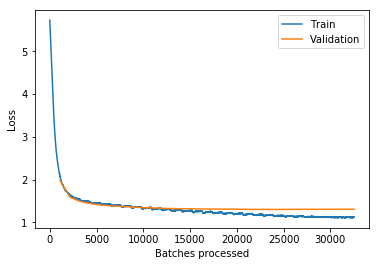

In [77]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy', name=f'{model_name}-fitted')
learn.fit_one_cycle(epochs, lr, callbacks=callbacks); learn.recorder.plot_losses()

### Predictions

In [25]:
learn = tabular_learner(data, layers=[727,353], ps=p, emb_drop=p, metrics=accuracy)
learn.load(f'{model_name}-fitted')

Learner(data=TabularDataBunch;

Train: LabelList (1111977 items)
x: TabularList
assigned_to_group OpsTechIT-SLC1; case_type Trouble Ticket; category OpsTechIT; channel rt Manual; first_assigned_group OpsTechIT; impact 5; isriver False; item Mobile Cart; site SLC1-FC ARS(Salt Lake City,UT); site_building_type Sort-AR; site_city Salt Lake City; site_country US; site_loc_bldg_cd SLC1; site_region #na#; site_state UT; type Client Devices; lang en; short_description_has_link False; ticketed_by_infra_scripts False; ticketed_by_itm_core False; ticketed_by_itm_consoles False; ticketed_by_itm_fcnapmon False; ticket_created_by_user False; ticket_created_by_flx_river False; ticket_created_by_flx_cstech False; ticket_created_by_infra_scripts False; contains_defect_details_str False; slim_ticket False; mdf_room_status_check False; policy_number #na#; policy_section #na#; amz_domain_policy False; amz_domain_tiny False; amz_domain_it_monitoring False; amz_domain_w False; amz_domain_carnaval False; am

In [26]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [27]:
preds

tensor([[8.1752e-03, 1.2569e-08, 3.5572e-07,  ..., 1.0384e-03, 1.1994e-03,
         1.2671e-07],
        [6.0268e-05, 9.6619e-07, 1.5352e-07,  ..., 7.8163e-02, 3.2218e-03,
         1.2821e-06],
        [1.5193e-04, 4.8463e-12, 5.0050e-10,  ..., 1.0692e-05, 5.6369e-06,
         5.3415e-12],
        ...,
        [9.0690e-05, 1.1029e-11, 1.4400e-09,  ..., 1.0557e-03, 5.5880e-05,
         2.6606e-09],
        [2.4591e-08, 9.2173e-11, 8.5464e-11,  ..., 5.5447e-04, 1.2229e-05,
         5.0002e-11],
        [8.2640e-05, 1.1994e-12, 1.8800e-11,  ..., 9.1816e-06, 2.3361e-05,
         9.0484e-13]])

In [28]:
pred_classes = [data.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [29]:
df_out = pd.DataFrame({'ID': df_raw_test['ID'], 'root_cause': pred_classes})

In [30]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_naive_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_naive_2019_05_11_01_09_tab-v4-stage-6.csv

* public leaderboard: 0.587244245137

### Interpretation

In [31]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)

In [32]:
pred_classes = [data.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [33]:
df_val = df_raw.iloc[split[1]].copy()
df_val['root_cause_pred'] = pred_classes
df_val['match'] = df_val['root_cause'] == df_val['root_cause_pred']

In [34]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_val_mimatches_exploration.csv'
df_val.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_11_01_11_val_mimatches_exploration.csv

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

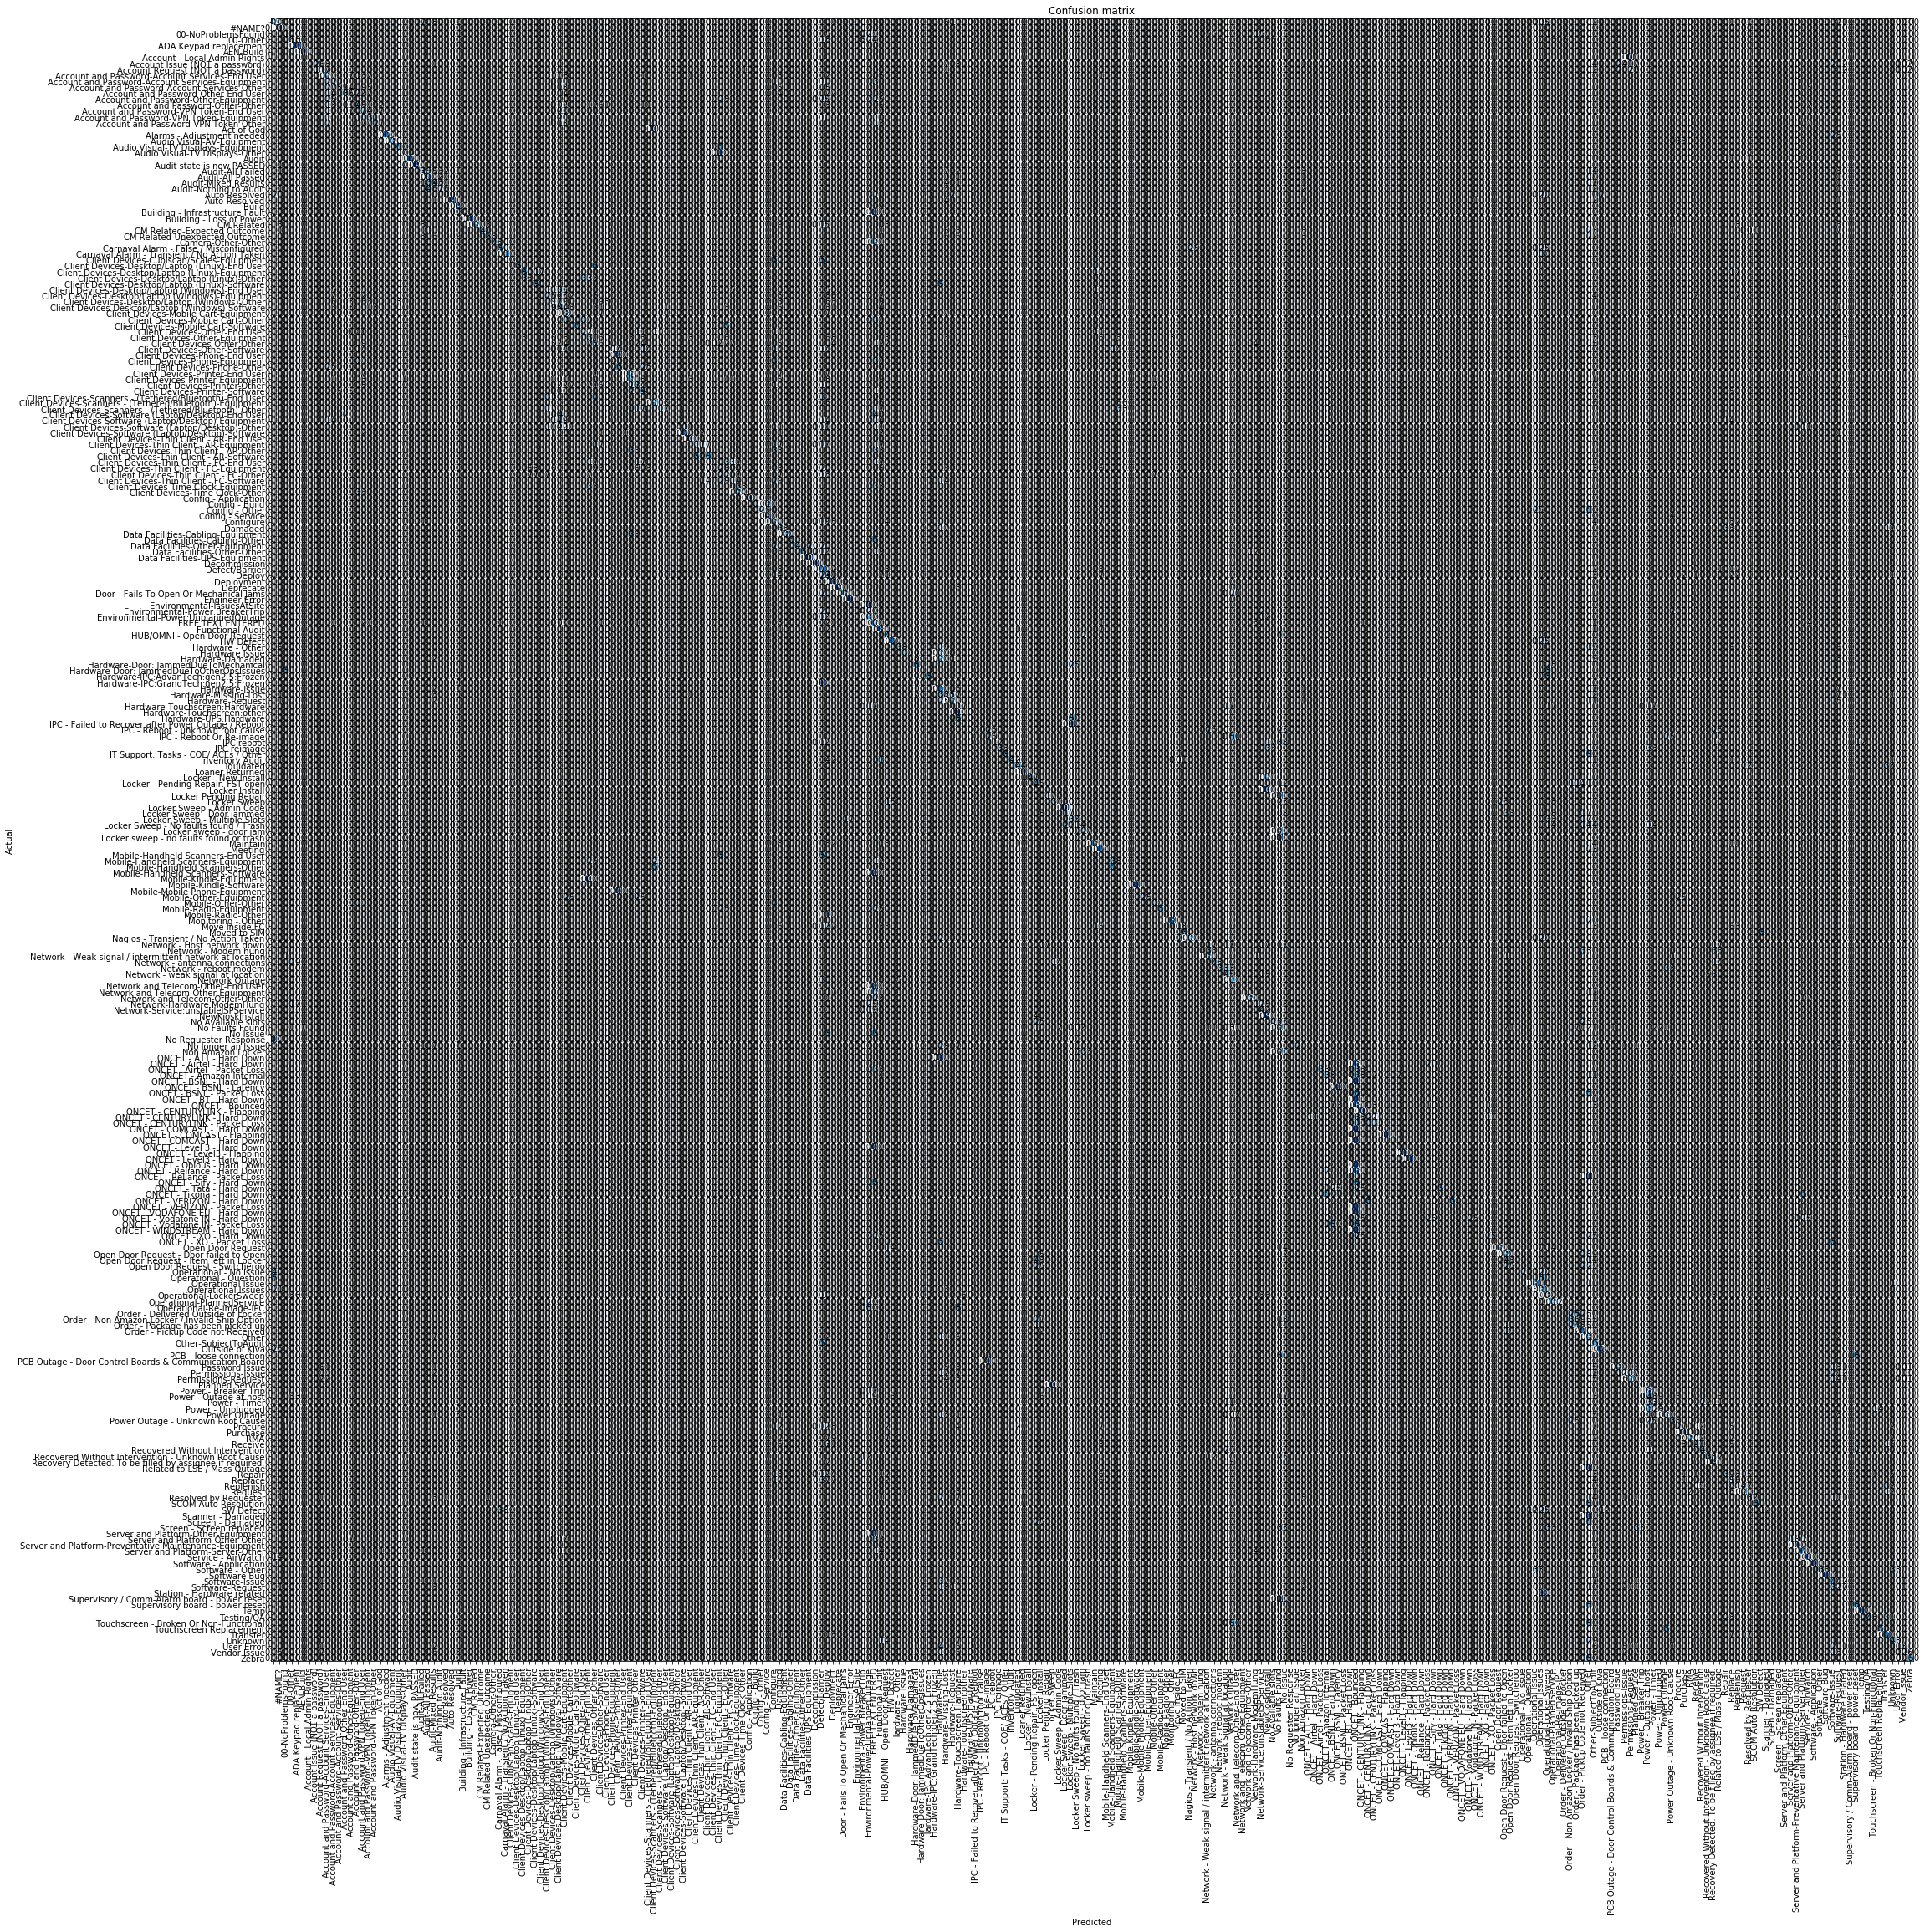

In [36]:
interp.plot_confusion_matrix(figsize=(32,32), normalize=True)

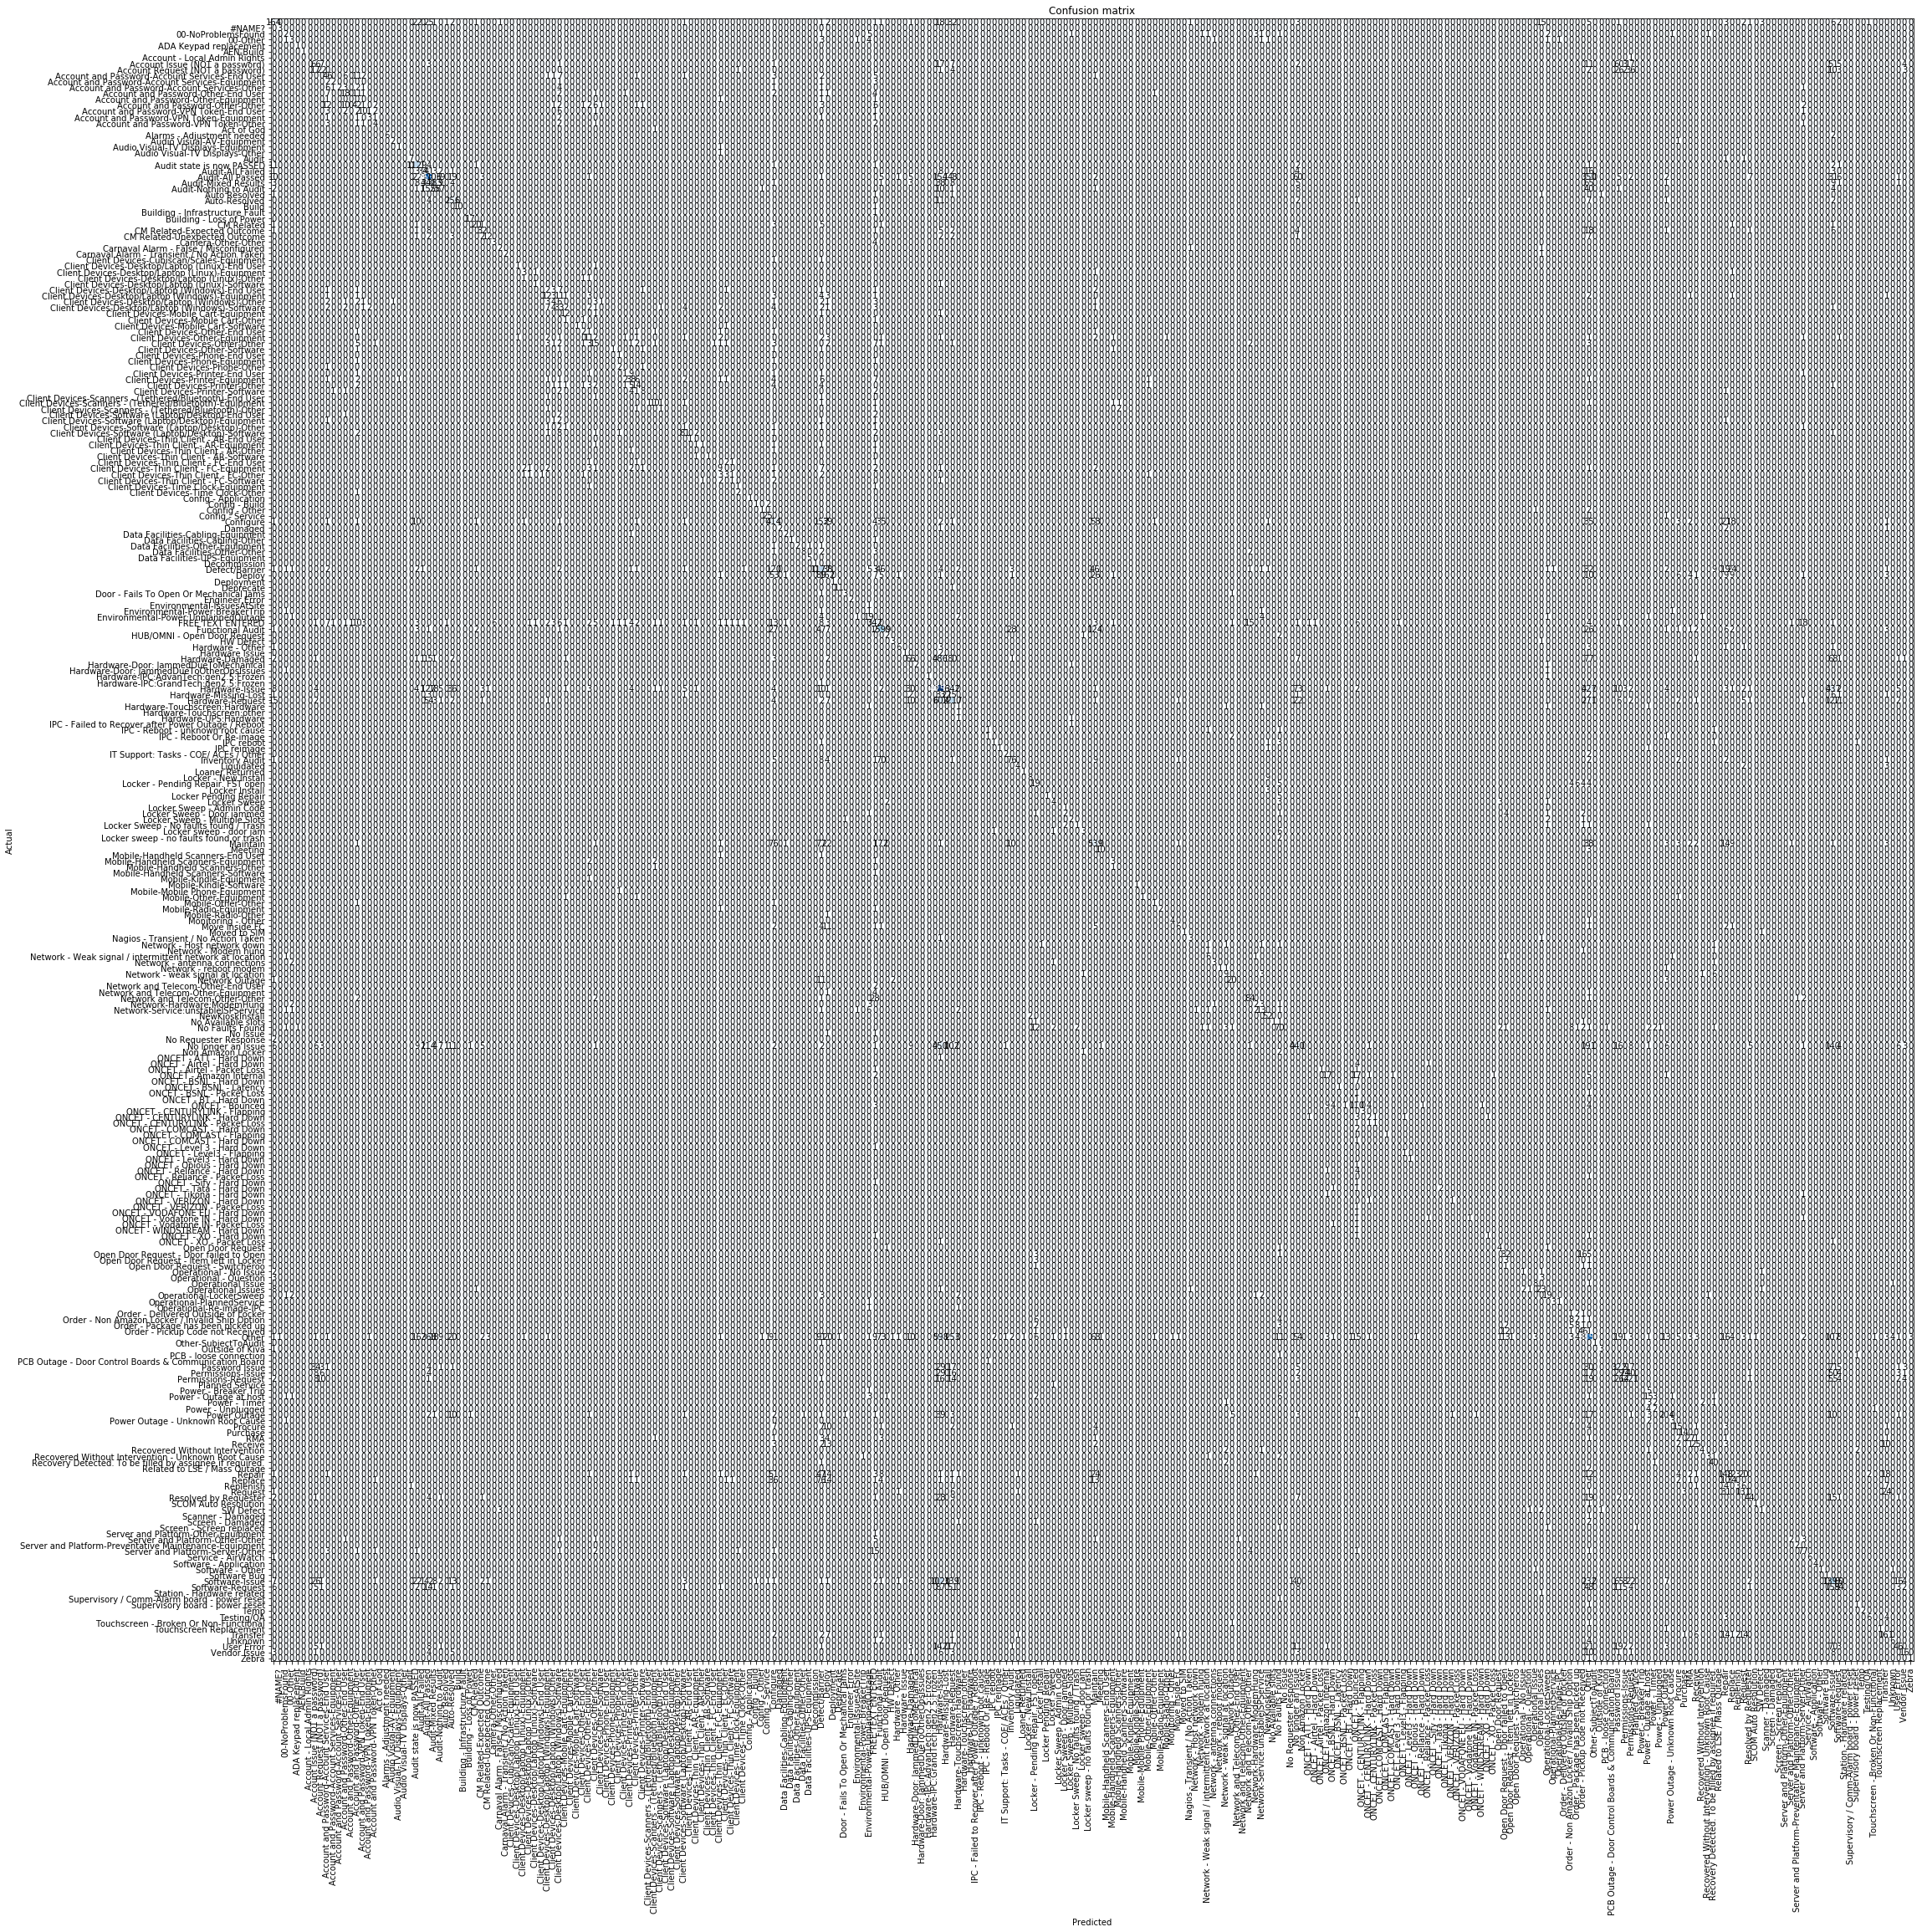

In [37]:
interp.plot_confusion_matrix(figsize=(32,32))